<a href="https://colab.research.google.com/github/melissaortegaa/monografia/blob/main/04_transfer_learning_resnet50v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

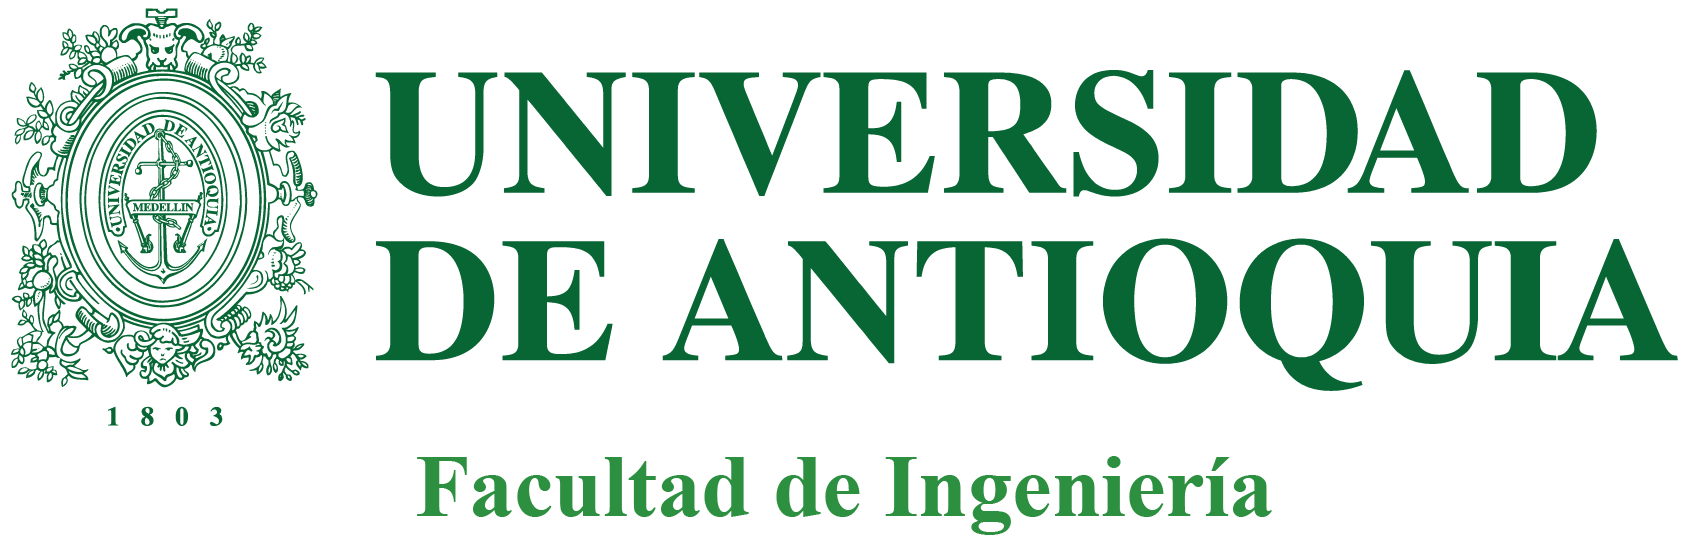
---

**Especialización en Analítica y Ciencia de Datos - Analytics & Data Science**

**Universidad de Antioquia**

**2024**

**Melissa Ortega Alzate**

---

# Redes neuronales convolucionales para la detección de Salmonella *spp.* en aves de corral
### Convolutional Neural Networks for the Detection of Salmonella spp. in Poultry

This notebook is the fourth part of a series of four notebooks associated with the project "Convolutional Neural Networks for the Detection of Salmonella spp. in Poultry". The other notebooks can be found in the associated GitHub repository linked below.

<div style="display: flex; align-items: center; justify-content: flex-end; position: fixed; bottom: 10px; right: 10px;">
  <a href="https://colab.research.google.com/github/tu-usuario/tu-repositorio" style="margin-right: 15px;">
    <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" style="height: 25px;">
  </a>
  <a href="https://github.com/melissaortegaa/monografia" style="margin-right: 15px;">
    <img src="https://img.shields.io/badge/GitHub-000?logo=github&logoColor=fff&style=flat" alt="View on GitHub" style="height: 25px;">
  </a>
</div>

## Objective
Train an image classification model using the pre-trained ResNet50v2 convolutional neural network on feacal poultry images. The model distinguishes between healthy and Salmonella.

## Summary
This notebook covers:


1. Data Preprocessing: Preparing images with techniques like data augmentation.
2. Initial Training: extraact images characteristics using the ResNet50v2 network on the training set and evaluating on the validation set.
3. Fine-tuning: Unfreezing specific layers for improved Salmonella classification.
4. Model Evaluation: Assessing the model's performance with confusion matrix visualization and metric comparison, including the test set.




# Init

### Imports

In [ ]:
# Standard library imports
import os
import sys
import random
import zipfile
import warnings
import time
import math
from pathlib import Path

# Visualization
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# Data manipulation and processing
import numpy as np
import pandas as pd

# Deep learning frameworks and utilities
import tensorflow as tf
from tensorflow.keras.applications.resnet_v2 import ResNet50V2, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras import backend as K

# Callbacks, regularizer and optimizers
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from tensorflow.keras.optimizers import Adam

# Keras tuner
!pip install keras-tuner -q
import keras_tuner
from keras_tuner.applications import HyperResNet

# Model evaluation
from sklearn.metrics import confusion_matrix, classification_report

# Ignore Warnings
warnings.filterwarnings("ignore")

# Clear any previous Keras session to avoid clutter from old models
K.clear_session()

# Set environment variables to reduce TensorFlow verbosity and CUDA issues
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

# Confirmation
print('\nThe modules were successfully loaded.')


The modules were successfully loaded.


In [ ]:
# Google Drive connection
!pip install -q gdown
import gdown
print('gdown was successfully installed and imported.')

gdown was successfully installed and imported.


### Tensorflow and devices settings

In [ ]:
# System configuration
if 'google.colab' in sys.modules:
    print("Setting TensorFlow version in Colab")
    %tensorflow_version 2.x

# Check TensorFlow version
print(f'TensorFlow version: {tf.__version__}')

TensorFlow version: 2.15.0


In [ ]:
# GPU configuration
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU.')
    try:
        for gpu in gpu_devices:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(f"{len(gpu_devices)} Physical GPUs, {len(logical_gpus)} Logical GPUs")
    except RuntimeError as e:
        print(e)
else:
    print('Using CPU.')

Using GPU.
1 Physical GPUs, 1 Logical GPUs


In [ ]:
# Hardware devices info
!nvidia-smi

Fri May 31 16:34:42 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla P100-PCIE-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0              33W / 250W |    256MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
# Fixing the random seeds for reproducibility
np.random.seed(0)         # NumPy random seed
tf.random.set_seed(0)     # TensorFlow random seed
random.seed(0)            # Python random seed

print("Random seeds are set for reproducibility.")

Random seeds are set for reproducibility.


# Functions

**Function to plot activation maps of a given model layer**

In [ ]:
# Function to plot activation maps of a given model layer
def plot_activations(model, layer_name,image_batch,label_batch, n_images=5, n_channels=10):
    """
    Plots the activations of a given intermediate layer for a batch of input images.

    Parameters:
    model: keras.Model - The model to extract the activations from.
    layer_name: str - The name of the intermediate layer to extract the activations from.
    train_generator: keras.utils.Sequence - The data generator for providing input images.
    n_images: int, optional - The number of input images to plot the activations for. Default is 5.
    n_channels: int, optional - The number of channels to plot. Default is 10.

    Returns:
    fig: matplotlib.figure.Figure - The figure containing the activation plots.
    """
    # Create a new model that includes the model and the intermediate layer
    intermediate_layer_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)

    # Ensure we only process the desired number of images
    image_batch = image_batch[:n_images]
    label_batch = label_batch[:n_images]

    # Print labels to check for variety
    print("Labels of selected images:", label_batch)

    # Extract the activations of the intermediate layer for the input images
    activations = intermediate_layer_model.predict(image_batch)
    num_channels = min(activations.shape[-1], n_channels)

    # Plot the activations for a subset of the input images
    fig, axes = plt.subplots(n_images, num_channels + 1, figsize=(2 * (num_channels + 1), 2 * n_images))
    for i in range(n_images):
        ax = axes[i, 0]
        ax.imshow(image_batch[i])
        ax.axis("off")
        for j in range(num_channels):
            ax = axes[i, j + 1]
            act = activations[i, :, :, j]
            ax.imshow(act, cmap=plt.cm.Greys_r)
            ax.axis("off")
    return fig

**Function to plot history of training**

In [ ]:
# Function to plot history of training
def plot_history(history, title='Model training history'):
    """
    Function to plot the training history of a model.

    Parameters:
    history: History object returned by the Keras fit method.
    title (str): Title for the plot.

    """
    # Convert the history to a DataFrame
    hist = pd.DataFrame.from_dict(history.history)
    hist['epoch'] = history.epoch
    max_epoch = hist['epoch'].max()

    # Determine if recall columns exist
    recall_columns = [col for col in hist.columns if 'recall' in col]
    num_plots = 3 if len(recall_columns) >= 2 else 2

    # Found best epochs
    val_lowest_index = hist['val_loss'].idxmin()
    val_lowest = hist['val_loss'].min()
    index_loss = hist['epoch'][val_lowest_index]

    val_max_index = hist['val_accuracy'].idxmax()
    val_max = hist['val_accuracy'].max()
    index_acc = hist['epoch'][val_max_index]

    val_recall_max_index = hist['val_recall'].idxmax()
    val_recall_max = hist['val_recall'].max()
    index_recall = hist['epoch'][val_recall_max_index]

    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'
    recall_label = f'best epoch= {str(index_recall + 1)}'

    # Create figure and axes
    fig, axes = plt.subplots(1, num_plots, figsize=(18, 6))
    fig.suptitle(title, fontsize=13,  fontweight='bold')

    # Ensure axes is always a list, even with a single subplot
    if num_plots == 1:
        axes = [axes]

    # Plot loss
    axes[0].plot(hist['epoch'], hist['loss'], 'o-r', label='Training')
    axes[0].plot(hist['epoch'], hist['val_loss'], '--', label='Validation')
    axes[0].set_xlim([0, max_epoch + 2])
    axes[0].set_ylim([0, max(hist['loss'].max(), hist['val_loss'].max()) * 1.1])
    axes[0].scatter(index_loss, val_lowest,s=60, c='green', label=loss_label)
    axes[0].set(ylabel='Loss', xlabel="Epochs")
    axes[0].set_title("Loss", fontweight='bold')
    axes[0].legend()

    # Plot accuracy
    axes[1].plot(hist['epoch'], hist['accuracy'], 'o-r', label='Training')
    axes[1].plot(hist['epoch'], hist['val_accuracy'], '--', label='Validation')
    axes[1].set_xlim([0, max_epoch + 2])
    axes[1].scatter(index_acc, val_max, s=60, c='green', label=acc_label)
    axes[1].set_ylim([hist['accuracy'].min() - 0.1, 1])
    axes[1].set(ylabel='Accuracy', xlabel="Epochs")
    axes[1].set_title('Accuracy', fontweight='bold')
    axes[1].legend()

    # Plot Recall (optional)
    if num_plots == 3:
        axes[2].plot(hist['epoch'], hist[recall_columns[0]], 'o-r', label='Training')
        axes[2].plot(hist['epoch'], hist[recall_columns[1]], '--', label='Validation')
        axes[2].set_xlim([0, max_epoch + 2])
        axes[2].set_ylim(([hist['accuracy'].min() - 0.1, 1]))
        axes[2].scatter(index_recall, val_recall_max, s=60, c='green', label=recall_label)
        axes[2].set(ylabel='Recall', xlabel="Epochs")
        axes[2].set_title("Recall", fontweight='bold')
        axes[2].legend()

    # Adjust space between subplots and title
    plt.tight_layout()
    plt.subplots_adjust(top=0.88)

    # Show the plot
    plt.show()


**Function to create confusion matrix**

In [ ]:
# Function to create confusion matrix
def plot_confusion_matrix(y_true, y_pred, normalize=False):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Create the confusion matrix
    fig = sns.heatmap(cm, cmap=plt.cm.YlGnBu, linewidths=.5,  fmt='.0f', cbar=False, annot=True, xticklabels=['Healthy', 'Salmonella'], yticklabels=['Healthy', 'Salmonella'])

    # Styling
    plt.title('Confusion matrix', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)
    plt.ylabel('True label', fontsize=12)
    plt.show()


    # Return the confusion matrix
    return fig

# Load the dataset

In [ ]:
# Download the preprocessed zip file from Google Drive
!gdown '13G-XzLgJx_94ZER7yT1j4lCK_srx2jQp' -O \
    /tmp/data1.zip

Downloading...
From (original): https://drive.google.com/uc?id=13G-XzLgJx_94ZER7yT1j4lCK_srx2jQp
From (redirected): https://drive.google.com/uc?id=13G-XzLgJx_94ZER7yT1j4lCK_srx2jQp&confirm=t&uuid=eeae1d0f-a2e4-4381-9de5-bfbb5edc8204
To: /tmp/data1.zip
100%|████████████████████████████████████████| 172M/172M [00:06<00:00, 26.4MB/s]


In [ ]:
# Define the path of the ZIP file and the extraction directory
local_zip = '/tmp/data1.zip'
extract_dir = '/tmp/data'

# Extract files from the ZIP archive
try:
    with zipfile.ZipFile(local_zip, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
    print("Extraction completed successfully.")
except Exception as e:
    print("Error during extraction:", e)

Extraction completed successfully.


In [ ]:
# Define directories
base_dir = '/tmp/data'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# Define subdirectories for each class
train_healthy_dir = os.path.join(train_dir, 'healthy')
train_salmo_dir = os.path.join(train_dir, 'salmo')

validation_healthy_dir = os.path.join(validation_dir, 'healthy')
validation_salmo_dir = os.path.join(validation_dir, 'salmo')

test_healthy_dir = os.path.join(test_dir, 'healthy')
test_salmo_dir = os.path.join(test_dir, 'salmo')

# Get lists of files in each folder
train_healthy_fnames = os.listdir(train_healthy_dir)
train_salmo_fnames = os.listdir(train_salmo_dir)

validation_healthy_fnames = os.listdir(validation_healthy_dir)
validation_salmo_fnames = os.listdir(validation_salmo_dir)

test_healthy_fnames = os.listdir(test_healthy_dir)
test_salmo_fnames = os.listdir(test_salmo_dir)

# Print example files names
print(f"Train data examples for 1st class: \n{train_healthy_fnames[:10]}")
print(f"\nTrain data examples for 2nd class: \n{train_salmo_fnames[:10]}")

Train data examples for 1st class: 
['healthy.1251.jpg', 'healthy.1036.jpg', 'healthy.1514.jpg', 'healthy.2004.jpg', 'pcrhealthy.309.jpg', 'healthy.1977.jpg', 'healthy.46.jpg', 'healthy.1989.jpg', 'healthy.1407.jpg', 'healthy.362.jpg']

Train data examples for 2nd class: 
['salmo.1882.jpg', 'salmo.943.jpg', 'salmo.676.jpg', 'salmo.1273.jpg', 'salmo.800.jpg', 'salmo.1599.jpg', 'salmo.1287.jpg', 'salmo.2067.jpg', 'salmo.2092.jpg', 'salmo.117.jpg']


# Data preprocessing and augmentation

In this section, three main transformations are applied to the training and validation images:

* Resizing: All images are resized to 224x224x3.
* Normalization: Images are rescaled to a 1/255 ratio so that all pixels are in a common scale, facilitating the training of the models.
* Augmentation: Rotations, shears, zooms, and flips are added to the training data.

In [ ]:
# Define training parameters
IMG_SIZE = 224
EPOCHS = 50          # Number of epochs to train the model. An epoch is an iteration over the entire x and y data provided
STEPS_PER_EPOCH = 20 # Total number of steps (batches of samples) before declaring one epoch finished and starting the next epoch
BATCH_SIZE = 32      # Number of samples per gradient update
VALIDATION_STEPS = 10

In [ ]:
# Transforms will be added to the images to increase the size of the datasets.
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches using train_datagen generator for categorical models.
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        color_mode='rgb',
        seed=42)

validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        color_mode='rgb',
        seed=42)

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        color_mode='rgb',
        shuffle=False,  # No shuffle for test data
        seed=42)

Found 4023 images belonging to 2 classes.
Found 753 images belonging to 2 classes.
Found 253 images belonging to 2 classes.


# ResNet50V2 transfer learning

In [ ]:
# Create the base model from the pre-trained model ResNet50v2 without top layers

base_model = ResNet50V2(weights='imagenet',         # Load weights pre-treined on ImageNet
                        include_top=False,          # Do nor include the ImageNet classifier at the top
                        input_shape=(IMG_SIZE, IMG_SIZE, 3),
                        )

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [ ]:
# Freeze the convolutional base layers to avoid them to update the weights during the training
base_model.trainable = False
base_model.summary()

Model: "resnet50v2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │          0 │ conv2_block1_pre… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 58, 58,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 56, 56,    │          0 │ conv2_block1_0_c

 Total params: 23,564,800 (89.89 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,564,800 (89.89 MB)

In [ ]:
# Obtain a batch of images and labels from the training generator
image_batch, label_batch = next(train_generator)

# Verify that the input shape matches the shape of the images in the batch
print("Input shape:", base_model.input_shape)
print("Image batch shape:", image_batch.shape)

# Pass the batch of images through the ResNet50v2 model and obtain the feature vectors
feature_batch = base_model(image_batch)

# Print the shape of the feature vectors
print("Feature batch shape:", feature_batch.shape)

Input shape: (None, 224, 224, 3)
Image batch shape: (32, 224, 224, 3)
Feature batch shape: (32, 7, 7, 2048)


This pre-trained model is used as a feature extractor, it converts each 224x224x3 image into a 7x7x512 block of features. An the end 32 characteristics maps are generated. That output will be then used to train some top layers on the dataset to get the predictions.

Labels of selected images: [[1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


I0000 00:00:1717173310.402410     122 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


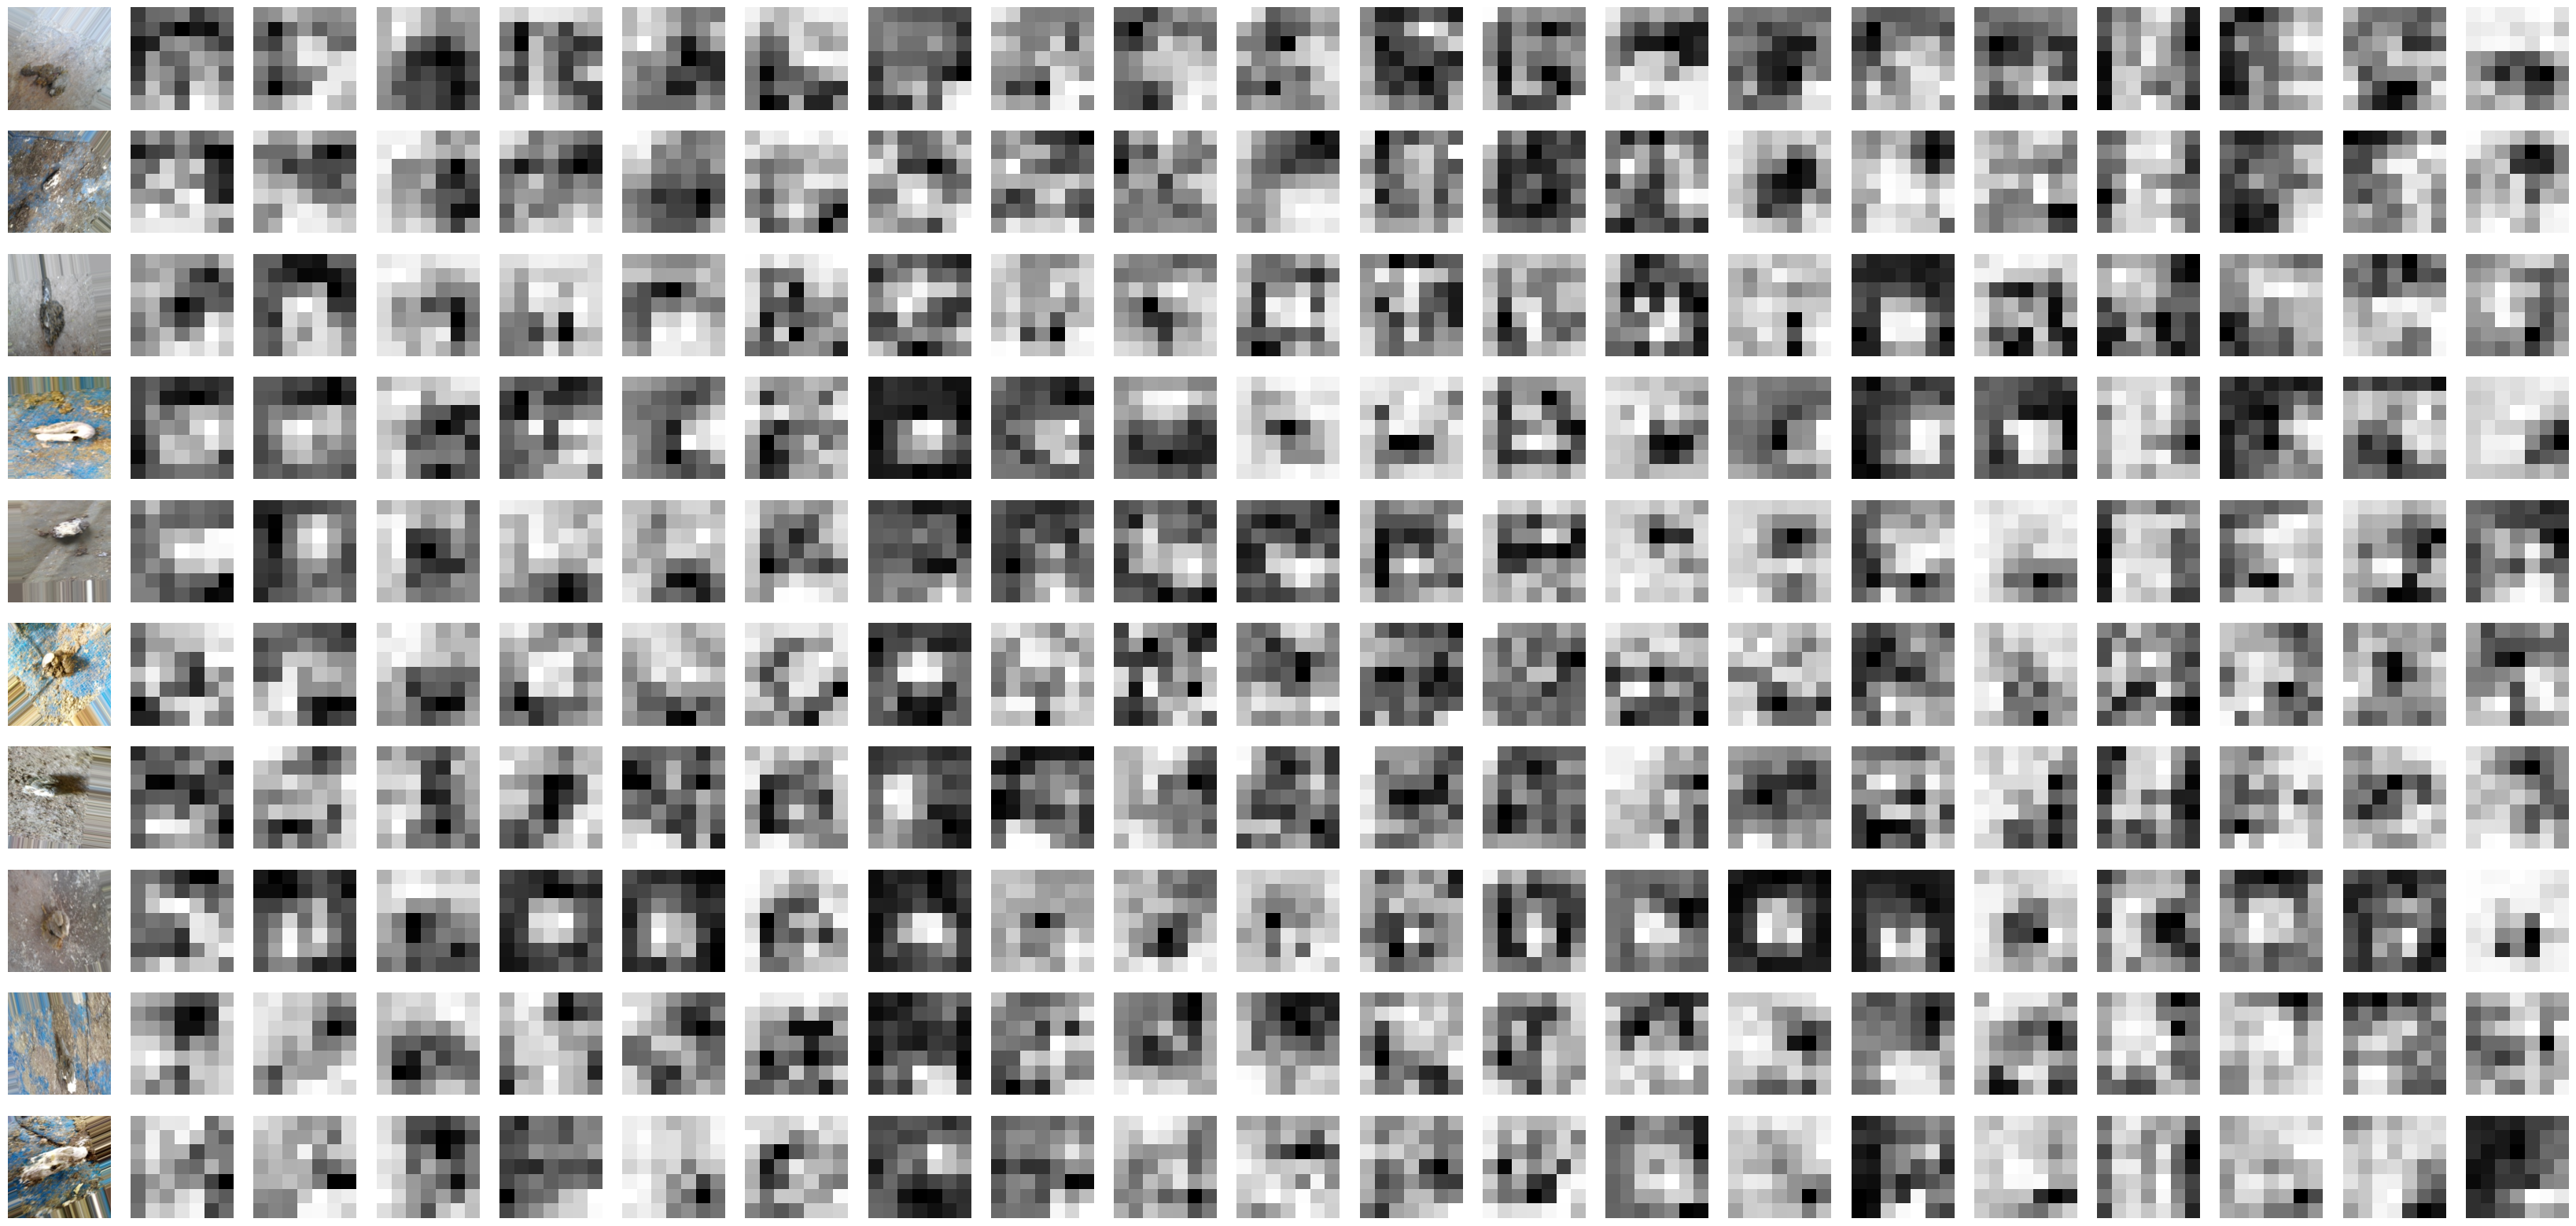

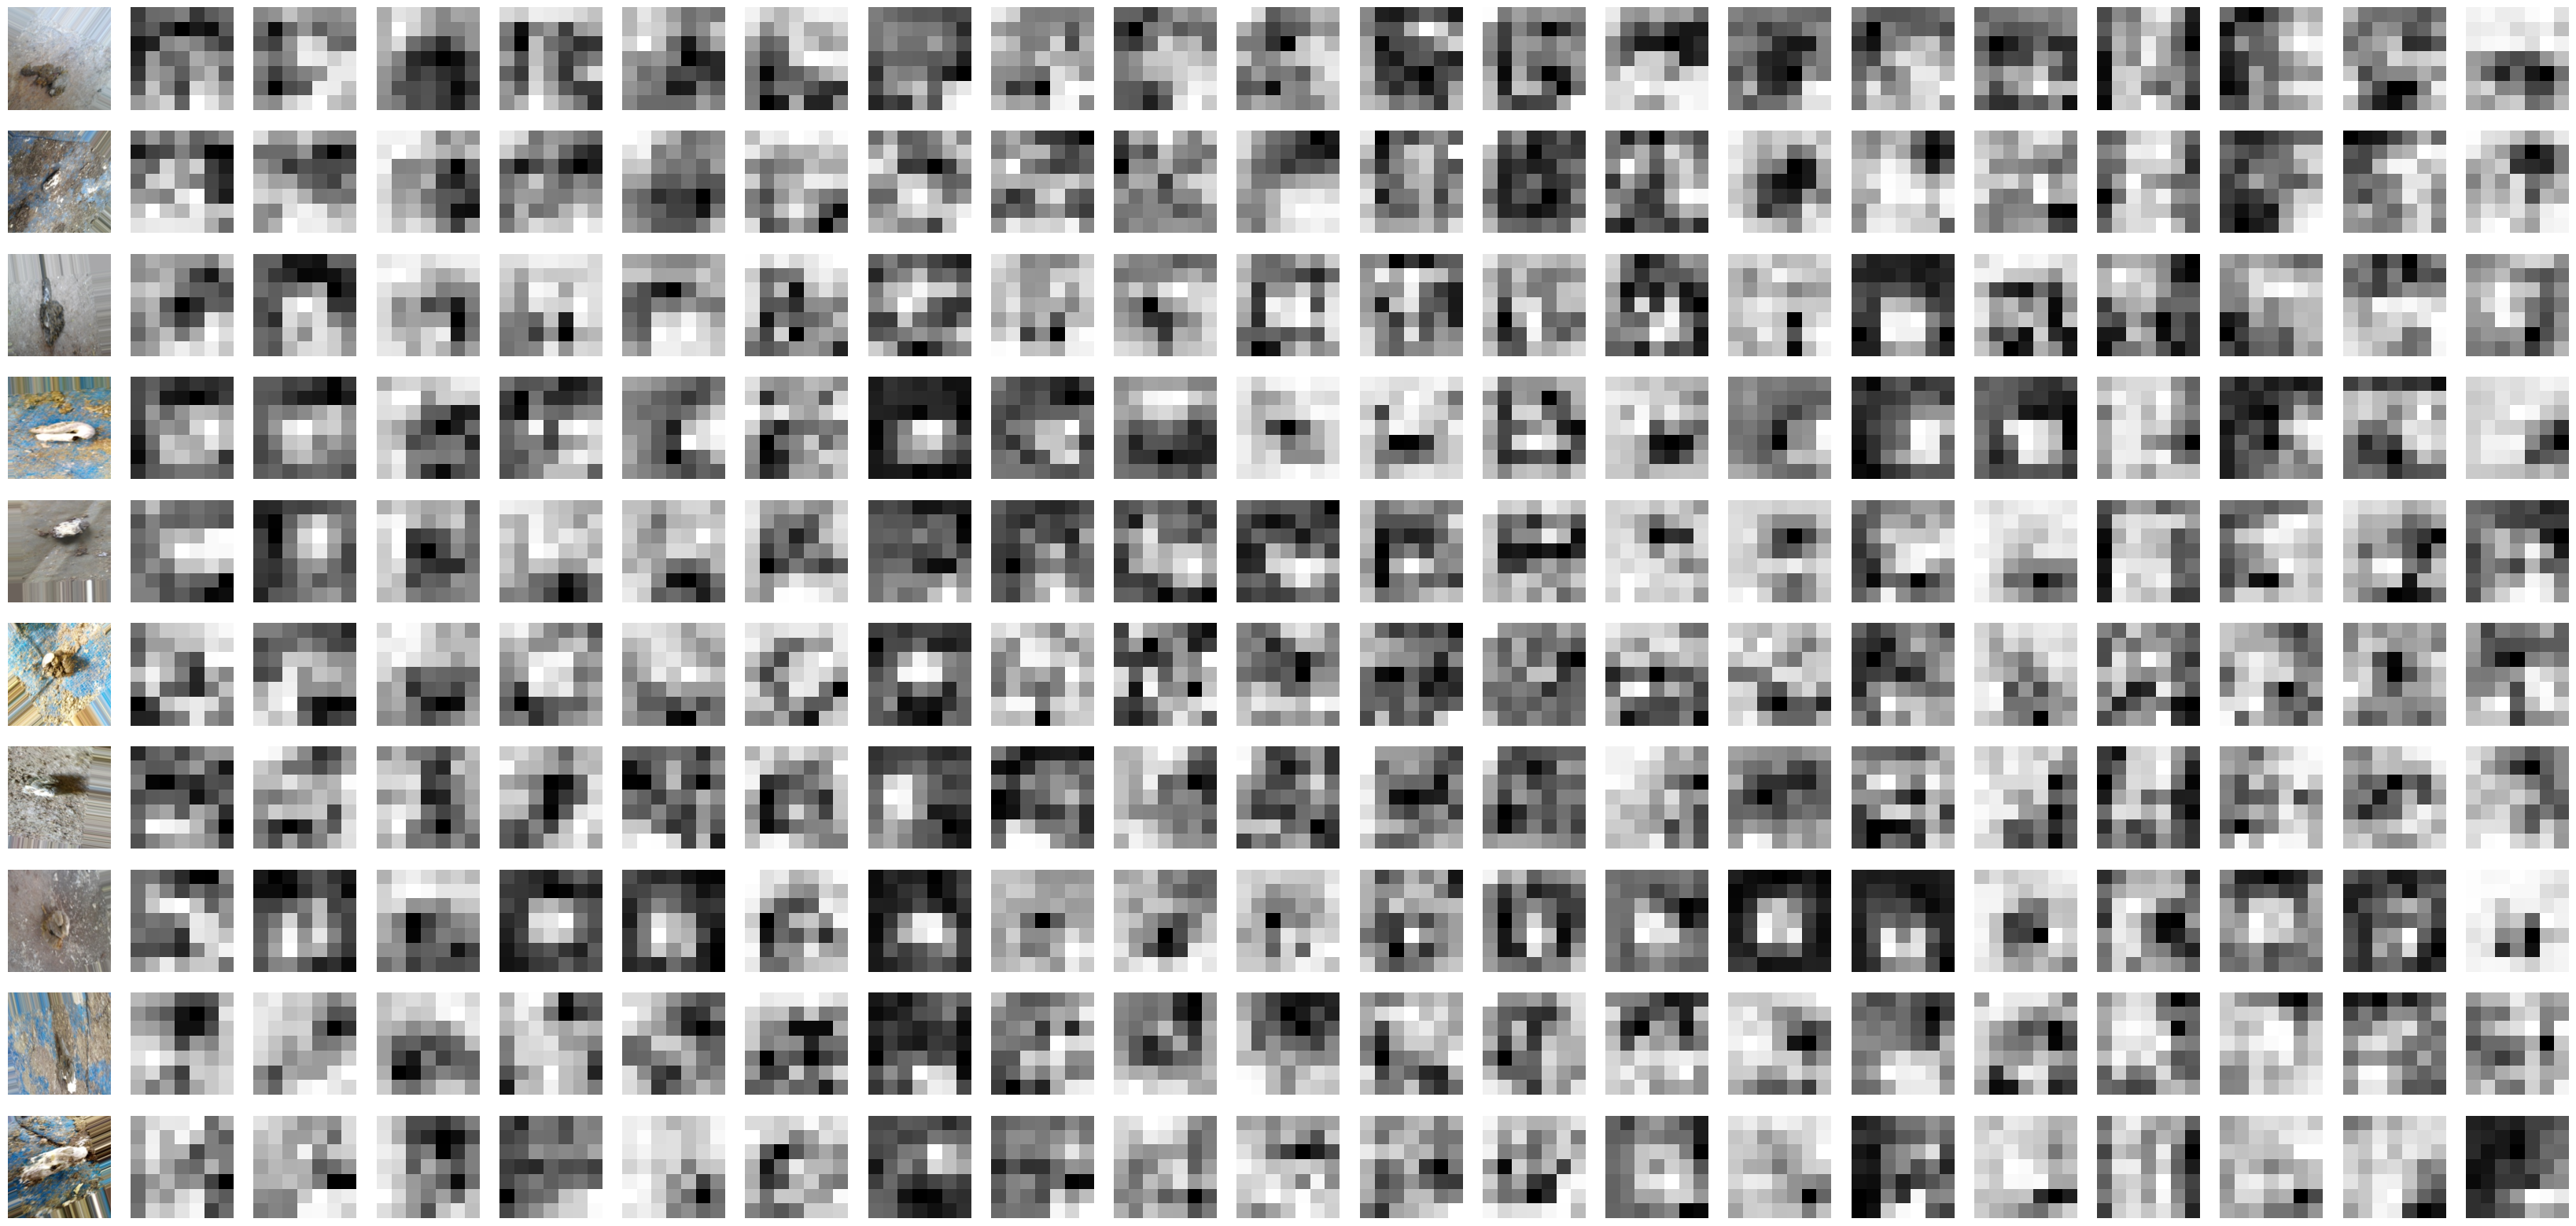

In [ ]:
# Plot activations
image_batch, label_batch = next(train_generator)
plot_activations(base_model, 'conv5_block3_out', image_batch, label_batch, n_images=10, n_channels=20)


## Add new layers to the ResNet50v2 model

Using Keras’ functional API to define the ResNet50v2 output as input into a new set of fully-connected layers like so:

In [ ]:
# Adding top custom Layers
x = base_model.output

# Convert features of shape 'base_model.output_shape[1:]' to vectors
x = GlobalAveragePooling2D()(x)

# Adding a dense and dropout layer
x = Dense(512, activation='relu')(x)
x = Dropout(0.5, seed=42)(x)

# Adding a dense classifier with softmax activation
output = Dense(2, activation='softmax',name='output')(x)

In [ ]:
# Define the new model
transfer_model = Model(inputs=base_model.input, outputs=output)
transfer_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │          0 │ conv2_block1_pre… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 58, 58,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 56, 56,    │          0 │ conv2_block1_0_c

 Total params: 24,614,914 (93.90 MB)

 Trainable params: 1,050,114 (4.01 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

In [ ]:
# Compile the model using the best baseline parameters
transfer_model.compile(loss='categorical_crossentropy',
              optimizer = Adam(learning_rate=0.0001),
              metrics=['accuracy', tf.keras.metrics.Recall()])

### Callbacks

In [ ]:
# Define early stopping parameters
earlystop = EarlyStopping(monitor='val_accuracy', patience=20, verbose=1, restore_best_weights=True)

# Define the ModelCheckpoint callback to save the best model based on the validation metric
checkpoint = ModelCheckpoint('best_resnet50_model.keras', monitor='val_accuracy', verbose=0, save_best_only=True, mode='max')

### Train the transfer model

In [ ]:
# Train the transfer model
history = transfer_model.fit(train_generator,
                            steps_per_epoch = STEPS_PER_EPOCH,
                            epochs = EPOCHS,
                            validation_data = validation_generator,
                            validation_steps = VALIDATION_STEPS,
                            verbose=1,
                            callbacks = [earlystop, checkpoint]
                            )

Epoch 1/50
 1/20 ━━━━━━━━━━━━━━━━━━━━ 5:26 17s/step - accuracy: 0.4375 - loss: 1.8615 - recall: 0.4375

W0000 00:00:1717173366.633959     123 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 676ms/step - accuracy: 0.5460 - loss: 1.0485 - recall: 0.5460

W0000 00:00:1717173383.780070     123 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


20/20 ━━━━━━━━━━━━━━━━━━━━ 36s 975ms/step - accuracy: 0.5496 - loss: 1.0360 - recall: 0.5496 - val_accuracy: 0.5844 - val_loss: 0.8320 - val_recall: 0.5844
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 352ms/step - accuracy: 0.7114 - loss: 0.5841 - recall: 0.7114 - val_accuracy: 0.6875 - val_loss: 0.5826 - val_recall: 0.6875
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 615ms/step - accuracy: 0.8051 - loss: 0.4572 - recall: 0.8051 - val_accuracy: 0.7080 - val_loss: 0.4773 - val_recall: 0.7080
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 297ms/step - accuracy: 0.7962 - loss: 0.3628 - recall: 0.7962 - val_accuracy: 0.7719 - val_loss: 0.4496 - val_recall: 0.7719
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 379ms/step - accuracy: 0.8245 - loss: 0.3797 - recall: 0.8245 - val_accuracy: 0.8281 - val_loss: 0.3465 - val_recall: 0.8281
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 339ms/step - accuracy: 0.8333 - loss: 0.3688 - recall: 0.8333 - val_accuracy: 0.8584 - val_loss: 0.3621 - val_recall: 0.8584
Epoch 7/50
20

## Evaluation and testing

### Histories plot

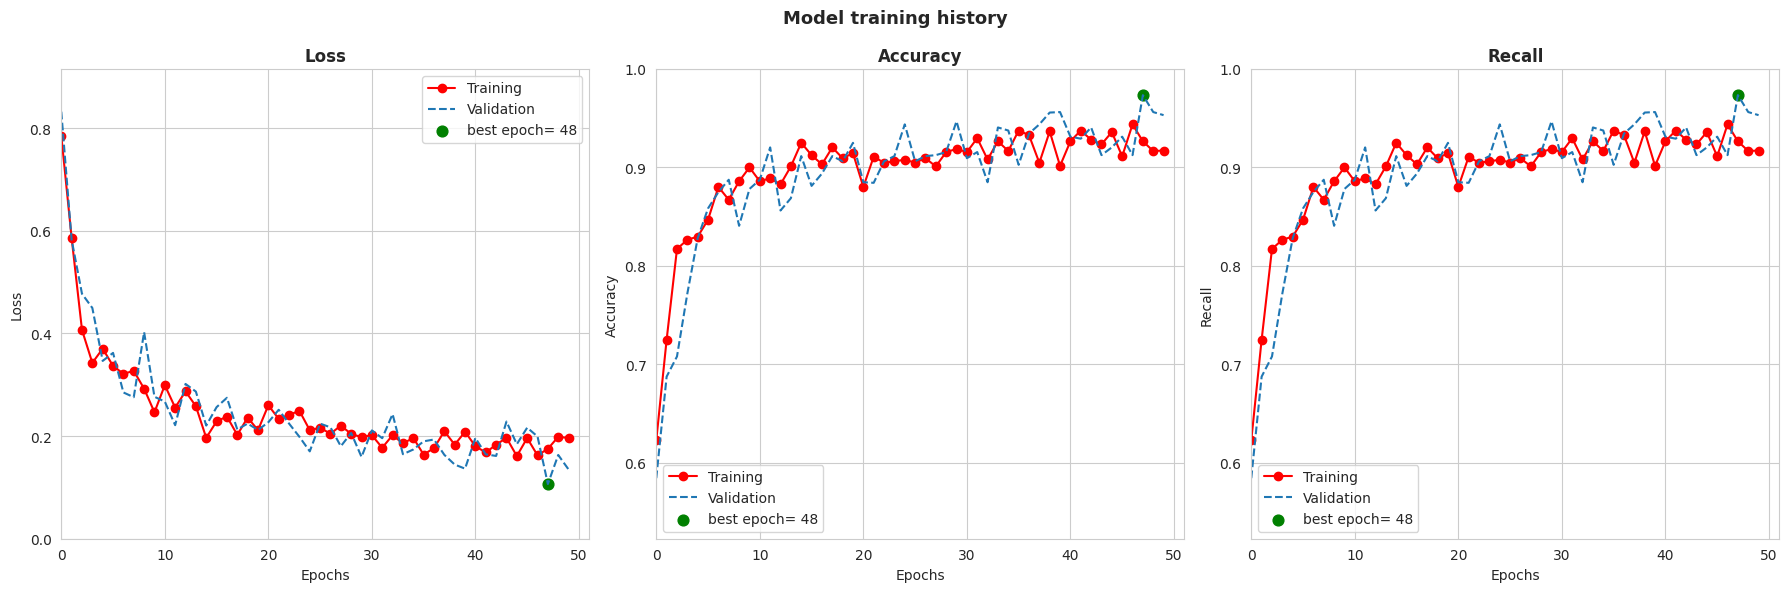

In [ ]:
# Plot learning curves
metrics = pd.DataFrame(history.history)
plot_history(history)

In [ ]:
# Display the best accuracy
print(f"\nThe best accuracy:")
history_model_acc = metrics.sort_values(by='accuracy', ascending=False)
display(history_model_acc.head(1))

# Display the best validation accuracy
print(f"\nThe best validation accuracy:")
history_model_val_acc = metrics.sort_values(by='val_accuracy', ascending=False)
display(history_model_val_acc.head(1))

# Display the best validation recall
print(f"\nThe best validation recall:")
val_recall_column = [col for col in metrics.columns if col.startswith('val_recall')]
history_model_val_rec = metrics.sort_values(by=val_recall_column[0], ascending=False)
display(history_model_val_rec.head(1))


The best accuracy:


accuracy      loss   recall  val_accuracy  val_loss  val_recall
46   0.94375  0.162446  0.94375        0.9125   0.19916      0.9125


The best validation accuracy:


accuracy      loss    recall  val_accuracy  val_loss  val_recall
47  0.926562  0.175214  0.926562      0.973451  0.106605    0.973451


The best validation recall:


accuracy      loss    recall  val_accuracy  val_loss  val_recall
47  0.926562  0.175214  0.926562      0.973451  0.106605    0.973451

### Confussion matrix

W0000 00:00:1717173710.842296     123 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


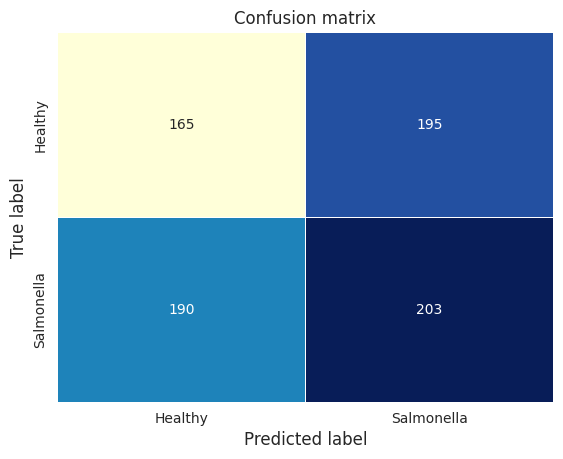

In [ ]:
# Evaluate the model on the validation set
preds = transfer_model.predict(validation_generator, verbose = 0)
y_pred = np.argmax(preds, axis=1)

# Get the true labels for the validation set
y_true = validation_generator.classes

# Calculate and plot the confusion matrix
plot_confusion_matrix(y_true, y_pred, normalize=False);

### Validation metrics

In [ ]:
# Create a DataFrame to store the results
results_df = pd.DataFrame(columns=['Model', 'Data Split', 'Loss', 'Accuracy', 'Recall', 'Time (s)', 'Params'])

# Evaluate the model on the training set
start_eval_time = time.time()
train_score = transfer_model.evaluate(train_generator, steps=VALIDATION_STEPS, verbose=0)
end_eval_time = time.time()
eval_time = end_eval_time - start_eval_time
params = transfer_model.count_params()
results_df.loc[len(results_df)] = ['Transfer ResNet50v2 model', 'Train', train_score[0], train_score[1], train_score[2], eval_time, params]

# Evaluate the model on the validation set
start_eval_time = time.time()
valid_score = transfer_model.evaluate(validation_generator, steps=VALIDATION_STEPS, verbose=0)
end_eval_time = time.time()
eval_time = end_eval_time - start_eval_time
results_df.loc[len(results_df)] = ['Transfer ResNet50v2 model', 'Validation', valid_score[0], valid_score[1], valid_score[2], eval_time, params]

# Evaluate the model on the test set
start_eval_time = time.time()
test_score = transfer_model.evaluate(test_generator, steps=VALIDATION_STEPS, verbose=0)
end_eval_time = time.time()
eval_time = end_eval_time - start_eval_time
results_df.loc[len(results_df)] = ['Transfer ResNet50v2 model', 'Test', test_score[0], test_score[1], test_score[2], eval_time, params]

# Display the results DataFrame
results_df

Model  Data Split      Loss  Accuracy    Recall  \
0  Transfer ResNet50v2 model       Train  0.131639  0.946875  0.946875   
1  Transfer ResNet50v2 model  Validation  0.177959  0.925000  0.925000   
2  Transfer ResNet50v2 model        Test  0.201809  0.920949  0.920949   

   Time (s)    Params  
0  4.394284  24614914  
1  0.602704  24614914  
2  6.340800  24614914

## Fine-tuning weights

In [ ]:
# Unfreeze the base model
base_model.trainable = True

# How many layers are in the base model
layer_in_base_model = len(base_model.layers)
print(f"Number of layers in the base model: {layer_in_base_model}")

Number of layers in the base model: 190


In [ ]:
# Fine-tune from this layer onwards
layer_to_unfreeze = 7
start_fine_tuning_at = layer_in_base_model - layer_to_unfreeze
print(f'Start fine tuning at: {start_fine_tuning_at}')

# Freeze all the layers before the `start_fine_tuning_at` layer
for layer in base_model.layers[:start_fine_tuning_at]:
    layer.trainable = False

Start fine tuning at: {start_fine_tuning_at}


In [ ]:
# See how many parameters are now trainable
transfer_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │          0 │ conv2_block1_pre… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 58, 58,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 56, 56,    │          0 │ conv2_block1_0_c

 Total params: 26,715,144 (101.91 MB)

 Trainable params: 4,465,154 (17.03 MB)

 Non-trainable params: 20,149,760 (76.87 MB)

 Optimizer params: 2,100,230 (8.01 MB)

In [ ]:
# Define the base learning rate
base_learning_rate = 0.0001

# Compile the transfer_model with the specified configuration
transfer_model.compile(
    loss='categorical_crossentropy',
    optimizer= Adam(learning_rate=base_learning_rate / 10),  # Using Adam optimizer with a very low learning rate
    metrics=['accuracy', tf.keras.metrics.Recall()]
)

In [ ]:
# Get the number of trainable variables
num_trainable_variables = len(transfer_model.trainable_variables)

# Print the number of trainable variables
print("Number of trainable variables:", num_trainable_variables)

# Get and print the list of trainable variables
print("\nList of trainable variables:")
transfer_model.trainable_variables

Number of trainable variables: 11

List of trainable variables:


[<KerasVariable shape=(3, 3, 512, 512), dtype=float32, path=conv5_block3_2_conv/kernel>,
 <KerasVariable shape=(512,), dtype=float32, path=conv5_block3_2_bn/gamma>,
 <KerasVariable shape=(512,), dtype=float32, path=conv5_block3_2_bn/beta>,
 <KerasVariable shape=(1, 1, 512, 2048), dtype=float32, path=conv5_block3_3_conv/kernel>,
 <KerasVariable shape=(2048,), dtype=float32, path=conv5_block3_3_conv/bias>,
 <KerasVariable shape=(2048,), dtype=float32, path=post_bn/gamma>,
 <KerasVariable shape=(2048,), dtype=float32, path=post_bn/beta>,
 <KerasVariable shape=(2048, 512), dtype=float32, path=dense/kernel>,
 <KerasVariable shape=(512,), dtype=float32, path=dense/bias>,
 <KerasVariable shape=(512, 2), dtype=float32, path=output/kernel>,
 <KerasVariable shape=(2,), dtype=float32, path=output/bias>]

### Continue training

In [ ]:
# Define the number of epochs for fine-tuning
fine_tune_epochs = 20

# Calculate the total number of including fine-tuning
total_epochs = EPOCHS + fine_tune_epochs

# Fine-tune the model
history_fine_tune = transfer_model.fit(
    train_generator,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],  # Resume training from the last epoch of previous training
    validation_data=validation_generator,
    callbacks=[earlystop, checkpoint]
)

Epoch 50/70
  1/126 ━━━━━━━━━━━━━━━━━━━━ 30:49 15s/step - accuracy: 0.9062 - loss: 0.2434 - recall_1: 0.9062

W0000 00:00:1717173742.838510     125 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


125/126 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step - accuracy: 0.9220 - loss: 0.2177 - recall_1: 0.9220

W0000 00:00:1717173792.273960     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


126/126 ━━━━━━━━━━━━━━━━━━━━ 67s 417ms/step - accuracy: 0.9221 - loss: 0.2176 - recall_1: 0.9221 - val_accuracy: 0.9442 - val_loss: 0.1734 - val_recall_1: 0.9442
Epoch 51/70
126/126 ━━━━━━━━━━━━━━━━━━━━ 45s 339ms/step - accuracy: 0.9206 - loss: 0.2033 - recall_1: 0.9206 - val_accuracy: 0.9402 - val_loss: 0.1745 - val_recall_1: 0.9402
Epoch 52/70
126/126 ━━━━━━━━━━━━━━━━━━━━ 46s 346ms/step - accuracy: 0.9301 - loss: 0.1892 - recall_1: 0.9301 - val_accuracy: 0.9416 - val_loss: 0.1710 - val_recall_1: 0.9416
Epoch 53/70
126/126 ━━━━━━━━━━━━━━━━━━━━ 45s 334ms/step - accuracy: 0.9382 - loss: 0.1706 - recall_1: 0.9382 - val_accuracy: 0.9349 - val_loss: 0.1762 - val_recall_1: 0.9349
Epoch 54/70
126/126 ━━━━━━━━━━━━━━━━━━━━ 44s 330ms/step - accuracy: 0.9414 - loss: 0.1584 - recall_1: 0.9414 - val_accuracy: 0.9429 - val_loss: 0.1639 - val_recall_1: 0.9429
Epoch 55/70
126/126 ━━━━━━━━━━━━━━━━━━━━ 44s 328ms/step - accuracy: 0.9431 - loss: 0.1578 - recall_1: 0.9431 - val_accuracy: 0.9495 - val_loss

### Histories plot

In [ ]:
# Concatenate the initial metrics with the fine-tuning metrics
metrics_tuned = pd.concat([metrics, pd.DataFrame(history_fine_tune.history)], ignore_index=True)

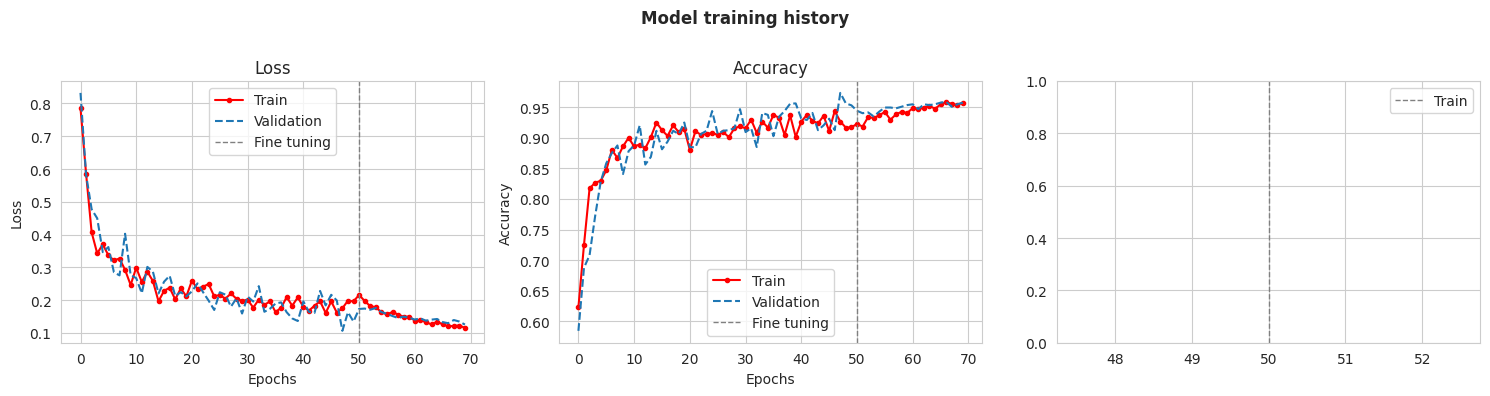

In [ ]:
fig, axes = plt.subplots(ncols=3, figsize=(15, 4))

# Plot loss
axes[0].plot(metrics_tuned['loss'], 'o-r',markersize=3)
axes[0].plot(metrics_tuned['val_loss'], '--')
axes[0].set(ylabel='Loss', xlabel="Epochs")
axes[0].set_title("Loss")
axes[0].legend()

# Plot accuracy
axes[1].plot(metrics_tuned['accuracy'], 'o-r', markersize=3 )
axes[1].plot(metrics_tuned['val_accuracy'], '--')
axes[1].set(ylabel='Accuracy', xlabel="Epochs")
axes[1].set_title('Accuracy')
axes[1].legend()

# Vertical line
for ax in axes:
    ax.axvline(EPOCHS, ls='--', lw=1, c='grey')
    ax.legend(['Train', 'Validation', 'Fine tuning'])

# Adjust space between subplots and general title
fig.suptitle("Model training history", fontsize = 12, weight='bold')
plt.tight_layout()
plt.subplots_adjust(top=0.80)

# Show the plot
plt.show()

In [ ]:
# Display the best accuracy
print(f"\nThe best accuracy:")
history_model_acc = metrics.sort_values(by='accuracy', ascending=False)
display(history_model_acc.head(1))

# Display the best validation accuracy
print(f"\nThe best validation accuracy:")
history_model_val_acc = metrics.sort_values(by='val_accuracy', ascending=False)
display(history_model_val_acc.head(1))

# Display the best validation recall
print(f"\nThe best validation recall:")
val_recall_column = [col for col in metrics.columns if col.startswith('val_recall')]
history_model_val_rec = metrics.sort_values(by=val_recall_column[0], ascending=False)
display(history_model_val_rec.head(1))


The best accuracy:


accuracy      loss   recall  val_accuracy  val_loss  val_recall
46   0.94375  0.162446  0.94375        0.9125   0.19916      0.9125


The best validation accuracy:


accuracy      loss    recall  val_accuracy  val_loss  val_recall
47  0.926562  0.175214  0.926562      0.973451  0.106605    0.973451


The best validation recall:


accuracy      loss    recall  val_accuracy  val_loss  val_recall
47  0.926562  0.175214  0.926562      0.973451  0.106605    0.973451

### Confussion matrix

W0000 00:00:1717174634.939869     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


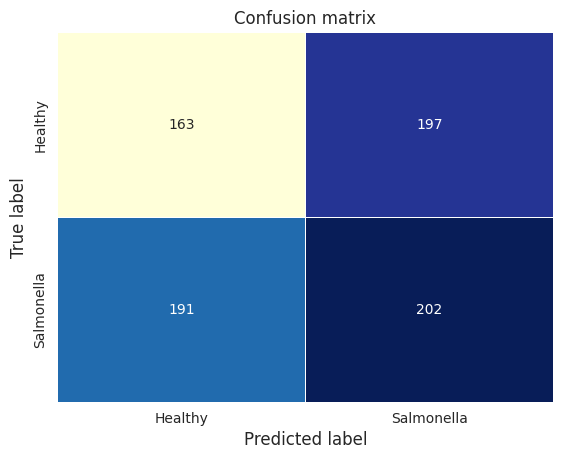

In [ ]:
# Evaluate the model on the validation set
preds = transfer_model.predict(validation_generator, verbose = 0)
y_pred = np.argmax(preds, axis=1)

# Get the true labels for the validation set
y_true = validation_generator.classes

# Calculate and plot the confusion matrix
plot_confusion_matrix(y_true, y_pred, normalize=False);

### Validation metrics

In [ ]:
# Define the data splits
data_splits = ['Train', 'Validation', 'Test']

# Create a DataFrame to store the results
results_df = pd.DataFrame(columns=['Model', 'Data Split', 'Loss', 'Accuracy', 'Recall', 'Time (s)', 'Params'])

# Evaluate the model for each data split
for split in data_splits:
    # Determine the generator to use based on the data split
    if split == 'Train':
        data_generator = train_generator
    elif split == 'Validation':
        data_generator = validation_generator
    else:
        data_generator = test_generator

    # Evaluate the model on the data split
    start_eval_time = time.time()
    score = transfer_model.evaluate(data_generator, steps=VALIDATION_STEPS, verbose=0)
    end_eval_time = time.time()
    eval_time = end_eval_time - start_eval_time
    params = transfer_model.count_params()

    # Store the results in the DataFrame
    results_df.loc[len(results_df)] = ['Transfer ResNet50v2 tuned model', split, score[0], score[1], score[2], eval_time, params]

# Display the results DataFrame
results_df

Model  Data Split      Loss  Accuracy    Recall  \
0  Transfer ResNet50v2 tuned model       Train  0.151803  0.956250  0.956250   
1  Transfer ResNet50v2 tuned model  Validation  0.180675  0.940625  0.940625   
2  Transfer ResNet50v2 tuned model        Test  0.201219  0.920949  0.920949   

   Time (s)    Params  
0  4.410534  24614914  
1  0.651453  24614914  
2  2.223732  24614914

# Visualize predictions

W0000 00:00:1717174655.514070     124 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


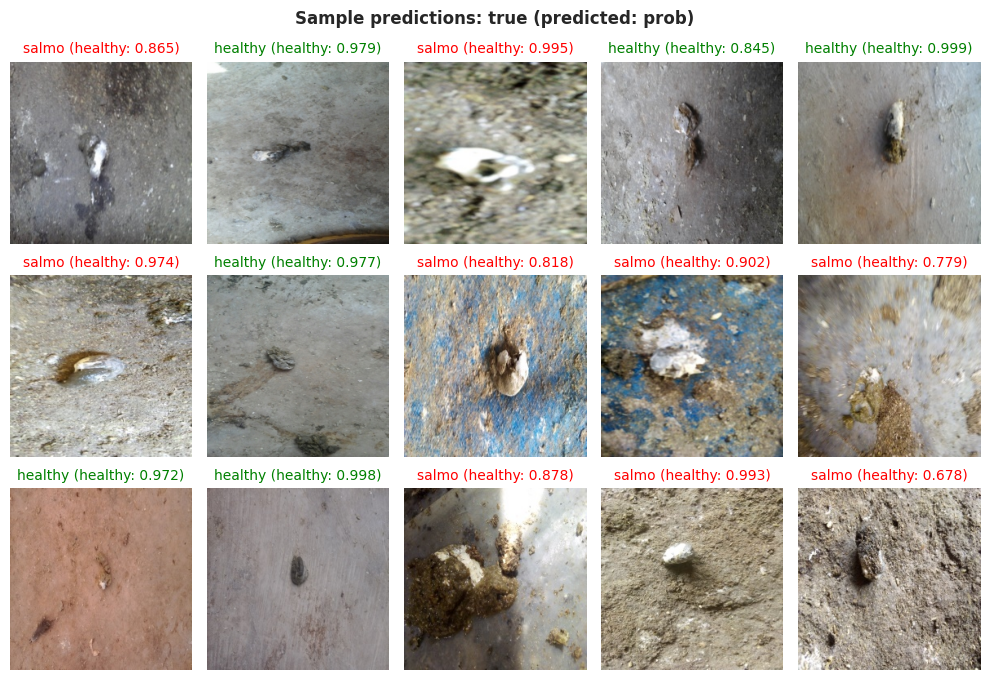

In [ ]:
# Cargar el mejor modelo guardado en el archivo "best_model.keras"
best_resnet50_model = load_model("best_resnet50_model.keras")

# Get probabilities and predictions labels for test images
y_prob = best_resnet50_model.predict(test_generator, verbose=0)
y_hat = np.argmax(y_prob, axis=1)

# Define class names
class_names = ['healthy', 'salmo']

# Create figure and subplots
fig, axs = plt.subplots(3, 5, figsize=(10, 7))
axs = axs.ravel()

# Choose random images from test set
indices = np.random.choice(len(test_generator.filenames), size=15, replace=False)

# Loop through images and display them with their predicted and true labels
for i, index in enumerate(indices):
    # Get image path and load image
    img_path = os.path.join(test_dir, test_generator.filenames[index])
    img = mpimg.imread(img_path)

    # Get true label of image
    if 'healthy' in os.path.basename(img_path):
        true_label = 'healthy'
    elif 'salmo' in os.path.basename(img_path):
        true_label = 'salmo'
    else:
        print('La imagen no pertenece a ninguna clase')

    # Get predicted label of image
    pred_label = class_names[y_hat[index]]
    pred_prob = y_prob[index][y_hat[index]]
    pred_label = 'salmo' if pred_label == 1 else 'healthy'

    # Display image in corresponding subplot
    ax = axs[i]
    ax.imshow(img)
    ax.set_title(f"{true_label} ({pred_label}: {pred_prob:.3f})", color="green" if pred_label == true_label else "red", fontsize=10)
    ax.axis('off')

# Add title to figure
fig.suptitle('Sample predictions: true (predicted: prob)', weight='bold', fontsize=12)
plt.tight_layout()
plt.show();

# Best model info

In [ ]:
# Load best_model.keras object
best_base_model = load_model('best_resnet50_model.keras')
best_base_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │          0 │ conv2_block1_pre… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 58, 58,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 56, 56,    │          0 │ conv2_block1_0_c

 Total params: 26,715,144 (101.91 MB)

 Trainable params: 1,050,114 (4.01 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

 Optimizer params: 2,100,230 (8.01 MB)